In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Constants
G = 1  # Set G = 1 for simplicity

# Milky Way-like parameters
M_b, a_b = 1.0, 0.2  # Bulge parameters
M_d, a_d, b_d = 5.0, 3.0, 0.3  # Disk parameters
v_h, r_c = 0.8, 8.0  # Halo parameters

In [28]:
x = np.linspace(-100,100,1000)
a=100
y2 = np.sin(a*x)# + np.sin(a/2*x) + np.sin(a/3*x)
y1 = a*x
y1, y2 = (y1 - y1.min())/(y1.max() - y1.min()), (y2 - y2.min())/(y2.max() - y2.min())
f1 = np.fft.fft(y1)
f2 = np.fft.fft(y2)
p1, p2 = np.abs(f1)**2, np.abs(f2)**2
half = len(p1) // 2
p1, p2 = p1[1:half], p2[1:half]  # Drop DC component (index 0)
p1, p2 = p1/p1.sum(), p2/p2.sum()
e1, e2 = -np.sum(p1 * np.log(p1 + 1e-12)), -np.sum(p2 * np.log(p2 + 1e-12))
print(e1, e2)

1.6315929213413023 1.0462877303632774


In [3]:
# Gravitational potentials
def phi_bulge(r):
    return -G * M_b / (r + a_b)

def phi_disk(R, z):
    return -G * M_d / np.sqrt(R**2 + (a_d + np.sqrt(z**2 + b_d**2))**2)

def phi_halo(r):
    return 0.5 * v_h**2 * np.log(r**2 + r_c**2)

# Full potential
def total_potential(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    R = np.sqrt(x**2 + y**2)
    return phi_bulge(r) + phi_disk(R, z) + phi_halo(r)

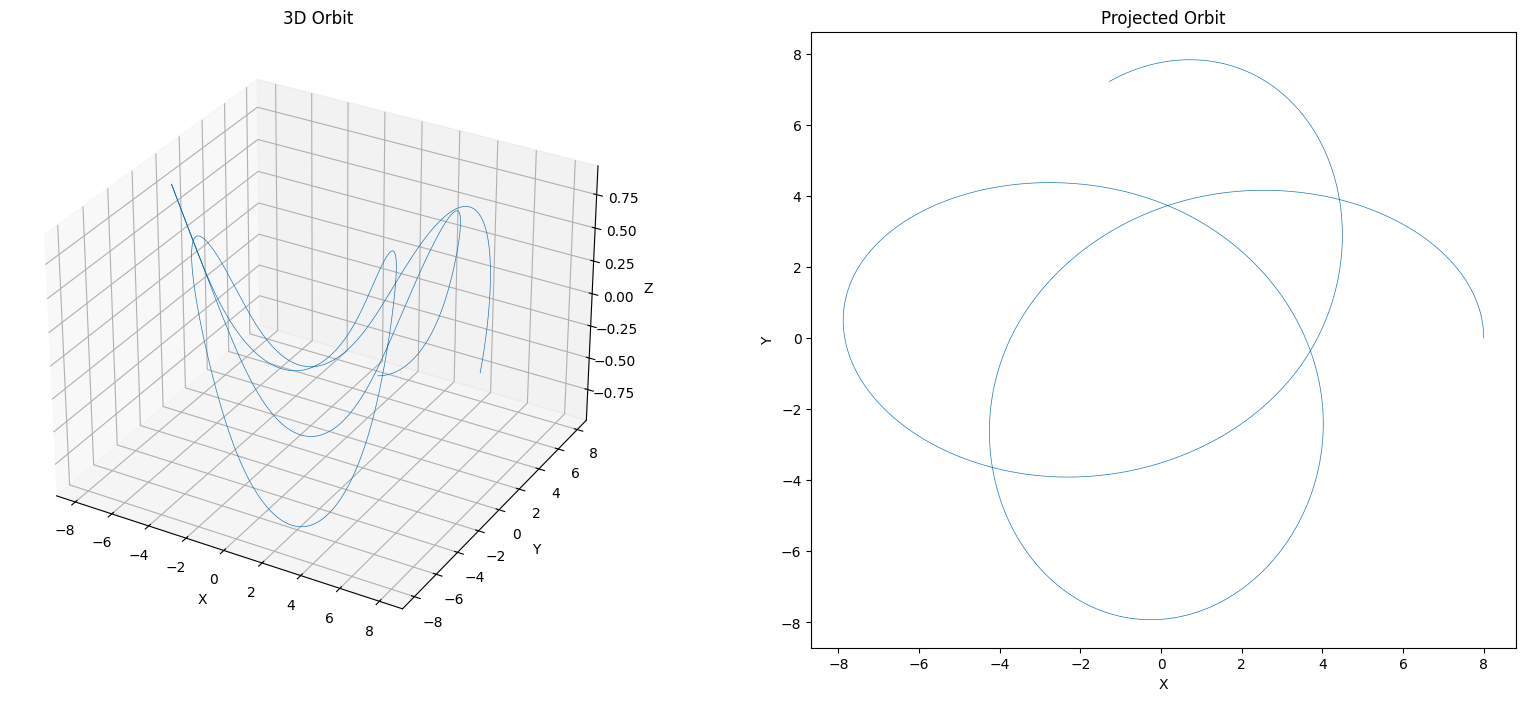

In [4]:
# Equations of motion (Hamiltonian formulation)
def equations(t, w):
    x, y, z, vx, vy, vz = w
    r = np.sqrt(x**2 + y**2 + z**2)
    R = np.sqrt(x**2 + y**2)

    # Compute forces
    dphi_b = -G * M_b / (r + a_b)**2
    dphi_h = -v_h**2 / (r**2 + r_c**2)
    dphi_d_R = -G * M_d * R / (R**2 + (a_d + np.sqrt(z**2 + b_d**2))**2)**(3/2)
    dphi_d_z = -G * M_d * (a_d + np.sqrt(z**2 + b_d**2)) * z / \
               (np.sqrt(z**2 + b_d**2) * (R**2 + (a_d + np.sqrt(z**2 + b_d**2))**2)**(3/2))

    # Accelerations
    ax = (dphi_b + dphi_h) * x / r + dphi_d_R * x / R
    ay = (dphi_b + dphi_h) * y / r + dphi_d_R * y / R
    az = (dphi_b + dphi_h) * z / r + dphi_d_z

    return [vx, vy, vz, ax, ay, az]

# Initial conditions
w0 = [8.0, 0.0, 0.0, 0.0, 0.5, 0.2]  # (x, y, z, vx, vy, vz)
# w0 = np.random.rand(3).tolist()+[0.0,0.0,0.0]
t_span = (0, 100)
t_eval = np.linspace(0, 100, 10000)

# Integrate the orbit
sol = solve_ivp(equations, t_span, w0, t_eval=t_eval, method='RK45')

# Plot the orbit
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(sol.y[0], sol.y[1], sol.y[2], lw=0.5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Orbit')

ax2 = fig.add_subplot(122)
ax2.plot(sol.y[0], sol.y[1], lw=0.5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Projected Orbit')

plt.show()